In [292]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
import os
import random
from IPython.display import display
from matplotlib import image
from sklearn.model_selection import train_test_split
import pickle
from datetime import datetime
from ipywidgets import widgets

In [243]:
def get_classes(dir_path):
    return os.listdir(dir_path)

def data_analysis_histogram(dir_path, classes, verbose = 1):
    class_dist = []
    for c in classes:
        class_path = os.path.join(dir_path,c)
        class_dist.append(len(os.listdir(class_path)))
    
    if verbose > 0:
        plt.figure(figsize=(16, 8))
        plt.title("Class distribution")
        plt.barh(classes, class_dist)
        for index, value in enumerate(class_dist):
            plt.text(value, index,str(value))
        plt.show()

def data_analysis_image_size(dir_path, classes, verbose = 1, seed = -1):
    if seed>=0:
        random.seed(seed)
    random_class_path = os.path.join(dir_path,random.choice(classes))
    random_img_name = random.choice(os.listdir(random_class_path))
    random_img_path = os.path.join(random_class_path,random_img_name)
    img = image.imread(random_img_path)
    if verbose > 0:
        plt.figure(figsize=(16, 8))
        plt.title("%s - Height: %d px x Length: %d px" % (random_img_path,img.shape[0],img.shape[1]))
        plt.imshow(img)
    
    return (img.shape[0],img.shape[1],1)

def analyse_dataset(dir_path, verbose = 1, seed = -1):
    classes = get_classes(dir_path)
    data_analysis_histogram(dir_path,classes, verbose)
    input_shape = data_analysis_image_size(dir_path,classes, verbose, seed)
    return classes, input_shape


In [261]:
def load_dataset(dir_path, percentage = 1, verbose = 1):
    classes = get_classes(dir_path)
    img_array = []
    class_array = []
    for c in classes:
        class_path = os.path.join(dir_path,c)
        imgs_name = os.listdir(class_path)

        if percentage < 1:
            imgs_name = random.sample(imgs_name, k = int(len(imgs_name)*percentage))

        for i in imgs_name:
            img_array.append(image.imread(os.path.join(class_path,i)))
            class_array.append(c)
    if verbose > 0:
        print("Loaded %d images" % len(img_array))
    return np.array(img_array), np.array(class_array)

In [262]:
def split_dataset(x, y, val_size = 0.2, verbose = 1, seed = 42):
    x_train, x_val, y_train, y_val = train_test_split(x,  y, test_size=val_size, random_state=seed)
    if verbose > 0:
        print("Train size: %d\nValidation size: %d" % (len(x_train), len(x_val)))
    return x_train, x_val, y_train, y_val


In [263]:
def prepare_dataset_channel_position(x, input_shape):
    img_lin,img_col,n_channels = input_shape
    if keras.backend.image_data_format() == 'channels_first':
        x = x.reshape(x.shape[0], n_channels, img_lin, img_col)
        input_shape = (n_channels, img_lin, img_col)
    else:
        x = x.reshape(x.shape[0], img_lin, img_col, n_channels)
        input_shape = (img_lin, img_col, n_channels)
    return x, input_shape

def prepare_dataset_input(x, input_shape):
    x_scaled = x.astype('float32') / 255.0
    return prepare_dataset_channel_position(x_scaled, input_shape)

def prepare_dataset_output(y, classes):
    class_map = {x: i for i,x in enumerate(classes)}
    y_code = [class_map[word] for word in y]
    y_categorical = keras.utils.to_categorical(y_code, len(classes))
    inv_class_map = {v: k for k, v in class_map.items()}
    return y_categorical, inv_class_map

def prepare_dataset(x , y , classes, input_shape):
    x_scaled, input_shape = prepare_dataset_input(x, input_shape)
    y_categorical, inv_class_map = prepare_dataset_output(y, classes)
    return x_scaled , y_categorical, inv_class_map, input_shape

In [266]:
def create_model(input_shape, classes):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1),  padding='same', activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(len(classes), activation='softmax'))
    return model

In [279]:
def evaluate_model(model, x_train, x_val, y_train, y_val,  history, verbose = 1):
    scoreTrain = model.evaluate(x_train, y_train, verbose = verbose)
    scoreValidation = model.evaluate(x_val, y_val, verbose = verbose)

    if verbose > 0:
        print("Training loss: %.4f" % (scoreTrain))
        print("Validation loss: %.4f" % (scoreValidation))
        plt.figure(figsize=(16, 8))
        plt.plot(history.history['loss'], label="Loss")
        plt.show()
    return scoreTrain, scoreValidation


In [283]:
def save_result(model, history):
    input_dict = {'model': model, 'history': history, 'datetime': datetime.now()}
    file = open(input(), "w")
    str = repr(input_dict)
    file.write("data = " + str + "\n")
    file.close()
    print("Saved!")

In [269]:
classes, input_shape = analyse_dataset('../Alzheimer_s Dataset/train', 0)
x, y = load_dataset('../Alzheimer_s Dataset/train', 0.1 ,1)
x_train, x_val, y_train, y_val = split_dataset(x, y, 0.2, 1)
x_train_prepared , y_train_prepared, inv_class_map, input_shape = prepare_dataset(x_train , y_train , classes, input_shape)
x_val_prepared , y_val_prepared, _, _ = prepare_dataset(x_val , y_val , classes, input_shape)

Loaded 511 images
Train size: 408
Validation size: 103


In [265]:
model = create_model(input_shape, classes)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam')

history = model.fit(x_train_prepared, y_train_prepared,
                    batch_size=128,
                    epochs=100, verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 208, 176, 64)      640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 104, 88, 64)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 104, 88, 64)       36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 52, 44, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 44, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 146432)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

4/4 [==============================] - 1s 132ms/step - loss: 2.1117
Training loss: 2.3659
Validation loss: 2.1117


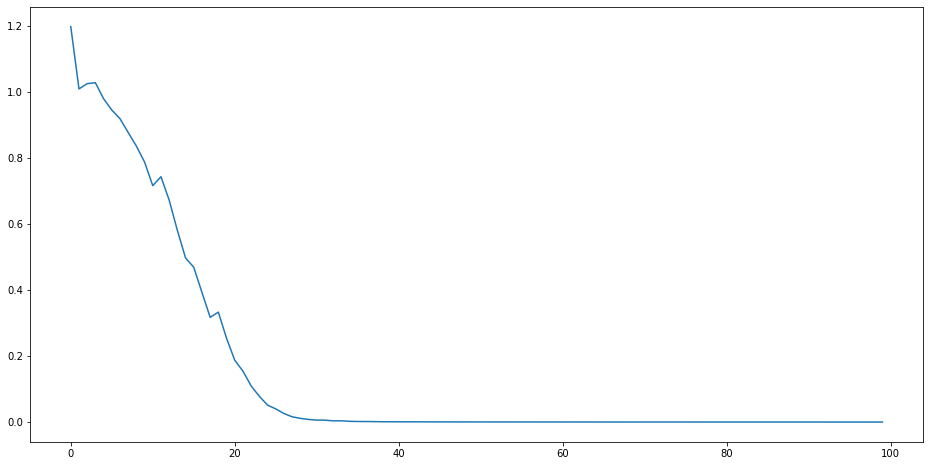

(2.365900754928589, 2.1117451190948486)

In [275]:
evaluate_model(model, x_train_prepared, x_val_prepared, y_train_prepared, y_val_prepared,  history, verbose = 1)